In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
df= pd.read_csv(r'C:\Users\Utente\Desktop\SAE-microbiome\francesco_Manco\data\df_MV-ASD_clr.csv')
df.head()

,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Defluviitaleaceae;_g__Defluviitaleaceae_UCG-011;_s__Lachnospiraceae_bacterium_feline_oral_taxon_001,d__Bacteria;_k__norank;_p__Proteobacteria;_c__Alphaproteobacteria;_o__Sphingomonadales;_f__Sphingomonadaceae;_g__Sphingopyxis;_s__Sphingopyxis_granuli,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erysipelotrichia;_o__Erysipelotrichales;_f__Erysipelotrichaceae;_g__Faecalicoccus;_s__unclassified_g__Faecalicoccus,d__Bacteria;_k__norank;_p__Firmicutes;_c__Bacilli;_o__Lactobacillales;_f__Streptococcaceae;_g__Streptococcus;_s__Streptococcus_anginosus_subsp._anginosus,d__Bacteria;_k__norank;_p__Tenericutes;_c__Mollicutes;_o__Mollicutes_RF9;_f__norank_o__Mollicutes_RF9;_g__norank_o__Mollicutes_RF9;_s__uncultured_bacterium_g__norank_o__Mollicutes_RF9,d__Bacteria;_k__norank;_p__Firmicutes;_c__Negativicutes;_o__Selenomonadales;_f__Veillonellaceae;_g__Negativicoccus;_s__uncultured_bacterium_g__Negativicoccus,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erysipelotrichia;_o__Erysipelotrichales;_f__Erysipelotrichaceae;_g__Erysipelatoclostridium;_s__[Clostridium]_spiroforme,d__Bacteria;_k__norank;_p__Bacteroidetes;_c__Bacteroidia;_o__Bacteroidales;_f__Bacteroidaceae;_g__Bacteroides;_s__Bacteroides_coprophilus,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Ruminococcaceae;_g__Ruminiclostridium_9;_s__uncultured_organism_g__Ruminiclostridium_9,d__Bacteria;_k__norank;_p__Actinobacteria;_c__Actinobacteria;_o__Corynebacteriales;_f__Corynebacteriaceae;_g__Corynebacterium;_s__Corynebacterium_durum,...,d__Bacteria;_k__norank;_p__Bacteroidetes;_c__Bacteroidia;_o__Bacteroidales;_f__Bacteroidaceae;_g__Bacteroides;_s__Bacteroides_plebeius.3,d__Bacteria;_k__norank;_p__Bacteroidetes;_c__Bacteroidia;_o__Bacteroidales;_f__Porphyromonadaceae;_g__Porphyromonas;_s__unclassified_g__Porphyromonas.1,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__unclassified_o__Clostridiales;_g__unclassified_o__Clostridiales;_s__unclassified_o__Clostridiales.14,d__Bacteria;_k__norank;_p__Proteobacteria;_c__Alphaproteobacteria;_o__Sphingomonadales;_f__Sphingomonadaceae;_g__Blastomonas;_s__uncultured_alpha_proteobacterium_g__Blastomonas,d__Bacteria;_k__norank;_p__Bacteroidetes;_c__Bacteroidia;_o__Bacteroidales;_f__Bacteroidaceae;_g__Bacteroides;_s__unclassified_g__Bacteroides.23,d__Bacteria;_k__norank;_p__Actinobacteria;_c__Actinobacteria;_o__Coriobacteriales;_f__Coriobacteriaceae;_g__Parvibacter;_s__uncultured_bacterium_g__Parvibacter,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Ruminococcaceae;_g__Ruminococcaceae_UCG-009;_s__uncultured_bacterium_g__Ruminococcaceae_UCG-009,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Lachnospiraceae;_g__Catonella;_s__unclassified_g__Catonella,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Christensenellaceae;_g__Christensenellaceae_R-7_group;_s__unclassified_g__Christensenellaceae_R-7_group.10,target
0,-0.675933,-0.675933,-0.675933,-0.675933,-0.675933,0.017214,-0.675933,-0.675933,3.255893,-0.675933,...,-0.675933,0.017214,-0.675933,-0.675933,-0.675933,-0.675933,-0.675933,-0.675933,-0.675933,1
1,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,1.653742,0.354459,...,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,-0.744153,1
2,-0.809010,-0.809010,-0.809010,-0.809010,-0.115863,-0.809010,-0.809010,5.377198,1.830047,-0.809010,...,-0.809010,-0.809010,-0.809010,-0.809010,-0.809010,-0.809010,-0.809010,-0.809010,-0.809010,1
3,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,-0.084633,4.185064,2.112592,-0.777780,...,-0.084633,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,-0.777780,1
4,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,0.012894,1.622332,-0.680253,...,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,-0.680253,-0

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Converti in tensori
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # reshape per la classificazione
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Crea i DataLoader per il training e il test
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
input_dim = X_train.shape[1]
bottleneck_dim = 64
input_dim

1322

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()

        # Improved Encoder with increased dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, bottleneck_dim)
        )

        # Improved Decoder with regularization
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, input_dim)
        )

        # Classification layer with batch norm
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(bottleneck_dim),
            nn.Linear(bottleneck_dim, 1)
        )

    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstruction = self.decoder(bottleneck)
        classification = torch.sigmoid(self.classifier(bottleneck))
        return reconstruction, classification

In [18]:
# Training function with improved monitoring and logging
def train_autoencoder(model, train_loader, test_loader, num_epochs=100, device="cuda"):
    # Hyperparameters
    alpha = 0.5  # Adjusted weight for reconstruction loss
    learning_rate = 0.001
    early_stopping_patience = 15
    
    # Initialize optimizer with L2 regularization
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
    )

    # Loss functions
    criterion_reconstruction = nn.MSELoss()
    criterion_classification = nn.BCELoss()

    # Tracking metrics
    train_losses = []
    test_losses = []
    train_recon_losses = []
    train_class_losses = []
    test_recon_losses = []
    test_class_losses = []
    accuracies = []

    # Early stopping variables
    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_recon_loss = 0.0
        train_class_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            reconstruction, classification = model(inputs)
            
            # Calculate losses
            loss_reconstruction = criterion_reconstruction(reconstruction, inputs)
            loss_classification = criterion_classification(classification, labels)
            
            # Combined loss
            loss = alpha * loss_reconstruction + (1 - alpha) * loss_classification
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            # Accumulate losses
            train_loss += loss.item()
            train_recon_loss += loss_reconstruction.item()
            train_class_loss += loss_classification.item()

        # Calculate average training losses
        num_batches = len(train_loader)
        train_loss /= num_batches
        train_recon_loss /= num_batches
        train_class_loss /= num_batches

        # Validation Phase
        model.eval()
        test_loss = 0.0
        test_recon_loss = 0.0
        test_class_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                reconstruction, classification = model(inputs)
                
                # Calculate losses
                loss_reconstruction = criterion_reconstruction(reconstruction, inputs)
                loss_classification = criterion_classification(classification, labels)
                loss = alpha * loss_reconstruction + (1 - alpha) * loss_classification
                
                # Accumulate losses
                test_loss += loss.item()
                test_recon_loss += loss_reconstruction.item()
                test_class_loss += loss_classification.item()
                
                # Calculate accuracy
                predicted = (classification >= 0.5).float()
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        # Calculate average test metrics
        num_test_batches = len(test_loader)
        test_loss /= num_test_batches
        test_recon_loss /= num_test_batches
        test_class_loss /= num_test_batches
        accuracy = (correct_predictions / total_samples) * 100

        # Update learning rate scheduler
        scheduler.step(test_loss)

        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_recon_losses.append(train_recon_loss)
        train_class_losses.append(train_class_loss)
        test_recon_losses.append(test_recon_loss)
        test_class_losses.append(test_class_loss)
        accuracies.append(accuracy)

        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train - Total Loss: {train_loss:.4f}, Recon Loss: {train_recon_loss:.4f}, Class Loss: {train_class_loss:.4f}')
        print(f'Test - Total Loss: {test_loss:.4f}, Recon Loss: {test_recon_loss:.4f}, Class Loss: {test_class_loss:.4f}')
        print(f'Classification Accuracy: {accuracy:.2f}%')
        print('-' * 80)

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered. Best test loss: {best_test_loss:.4f}')
            model.load_state_dict(best_model_state)
            break

    # Create visualization of training results
    plot_training_results(train_losses, test_losses, train_recon_losses, train_class_losses, 
                         test_recon_losses, test_class_losses, accuracies)
    
    return model, best_model_state

def plot_training_results(train_losses, test_losses, train_recon_losses, train_class_losses, 
                         test_recon_losses, test_class_losses, accuracies):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot total losses
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(test_losses, label='Test Loss')
    axes[0, 0].set_title('Total Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Plot reconstruction losses
    axes[0, 1].plot(train_recon_losses, label='Train')
    axes[0, 1].plot(test_recon_losses, label='Test')
    axes[0, 1].set_title('Reconstruction Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    # Plot classification losses
    axes[1, 0].plot(train_class_losses, label='Train')
    axes[1, 0].plot(test_class_losses, label='Test')
    axes[1, 0].set_title('Classification Losses')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    
    # Plot accuracy
    axes[1, 1].plot(accuracies, label='Test Accuracy')
    axes[1, 1].set_title('Classification Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]
Train - Total Loss: 1.5179, Recon Loss: 2.4083, Class Loss: 0.6275
Test - Total Loss: 1.3905, Recon Loss: 2.0937, Class Loss: 0.6872
Classification Accuracy: 46.75%
--------------------------------------------------------------------------------
Epoch [2/100]
Train - Total Loss: 1.4006, Recon Loss: 2.3610, Class Loss: 0.4402
Test - Total Loss: 1.3676, Recon Loss: 2.0865, Class Loss: 0.6487
Classification Accuracy: 46.75%
--------------------------------------------------------------------------------
Epoch [3/100]
Train - Total Loss: 1.3175, Recon Loss: 2.3187, Class Loss: 0.3163
Test - Total Loss: 1.3115, Recon Loss: 2.0757, Class Loss: 0.5474
Classification Accuracy: 84.42%
--------------------------------------------------------------------------------
Epoch [4/100]
Train - Total Loss: 1.2575, Recon Loss: 2.2710, Class Loss: 0.2439
Test - Total Loss: 1.2459, Recon Loss: 2.0644, Class Loss: 0.4275
Classification Accuracy: 88.31%
-----------------------------------------

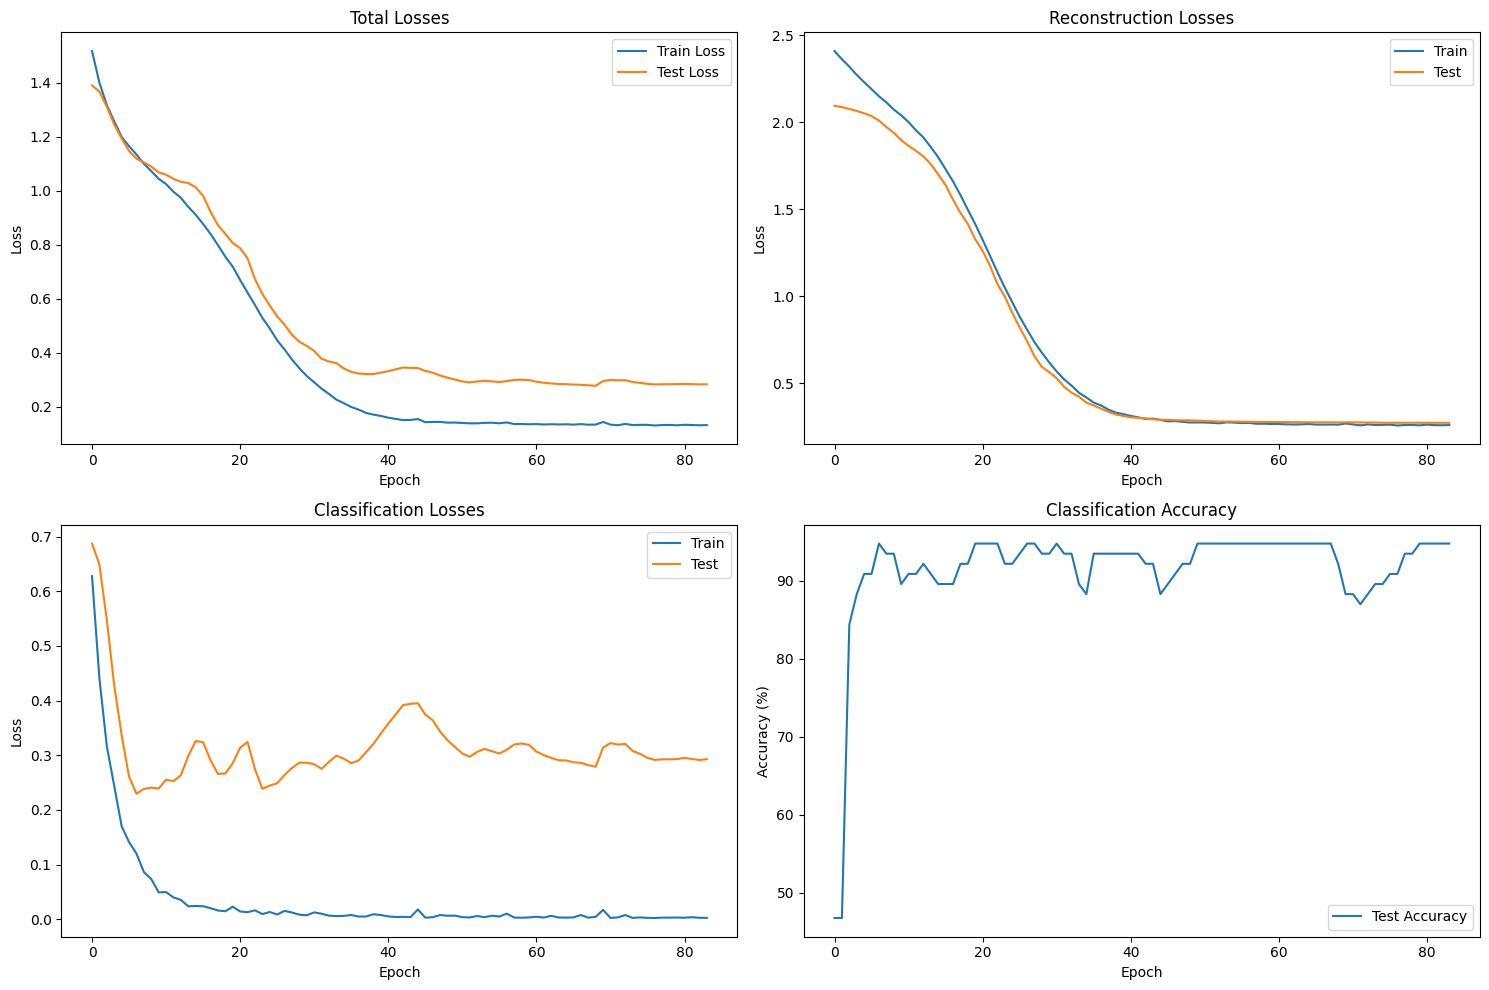

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_dim, bottleneck_dim).to(device)

# Train the model
model, best_state = train_autoencoder(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=100,
    device=device
)

In [13]:
class SAE(nn.Module):
    def __init__(self, input_shape, encoder_shape0, encoder_shape1, alpha):
        super(SAE, self).__init__()

        # Definire le layers
        self.encoder0 = nn.Linear(input_shape, encoder_shape0)
        self.encoder1 = nn.Linear(encoder_shape0, encoder_shape1)
        self.decoder = nn.Linear(encoder_shape1, input_shape)
        self.classification = nn.Linear(encoder_shape1, 1)

        # Funzioni di attivazione
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.alpha = alpha

        # Definire il criterio di regolarizzazione L2 (equivalente alla L2 nel Keras)
        self.l2_lambda = 0.00001

    def forward(self, x):
        # Encoder
        x = self.relu(self.encoder0(x))
        x = self.relu(self.encoder1(x))
        
        # Decoder (ricostruzione)
        decoded_output = self.decoder(x)

        # Classificazione
        classification_output = self.sigmoid(self.classification(x))

        return decoded_output, classification_output

    def loss_function(self, decoded_output, classification_output, target, classification_target):
        # Calcolare la perdita di ricostruzione (MSE)
        reconstruction_loss = nn.MSELoss()(decoded_output, target)

        # Calcolare la perdita di classificazione (Binary Cross-Entropy)
        classification_loss = nn.BCELoss()(classification_output, classification_target)

        # Calcolare la perdita totale, includendo la regolarizzazione L2
        l2_reg = 0
        for param in self.parameters():
            l2_reg += torch.norm(param)

        total_loss = self.alpha * reconstruction_loss + (1 - self.alpha) * classification_loss + self.l2_lambda * l2_reg

        return total_loss, reconstruction_loss, classification_loss





c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]
Train - Total Loss: 1.3808, Recon Loss: 2.0844, Class Loss: 0.6773
Test - Total Loss: 1.2808, Recon Loss: 1.9599, Class Loss: 0.6017
Classification Accuracy: 71.43%
--------------------------------------------------------------------------------
Epoch [2/100]
Train - Total Loss: 1.2525, Recon Loss: 1.8867, Class Loss: 0.6182
Test - Total Loss: 1.1226, Recon Loss: 1.6962, Class Loss: 0.5489
Classification Accuracy: 74.03%
--------------------------------------------------------------------------------
Epoch [3/100]
Train - Total Loss: 1.0746, Recon Loss: 1.5885, Class Loss: 0.5607
Test - Total Loss: 0.9371, Recon Loss: 1.3906, Class Loss: 0.4836
Classification Accuracy: 85.71%
--------------------------------------------------------------------------------
Epoch [4/100]
Train - Total Loss: 0.8981, Recon Loss: 1.3005, Class Loss: 0.4957
Test - Total Loss: 0.8182, Recon Loss: 1.1363, Class Loss: 0.5002
Classification Accuracy: 81.82%
-----------------------------------------

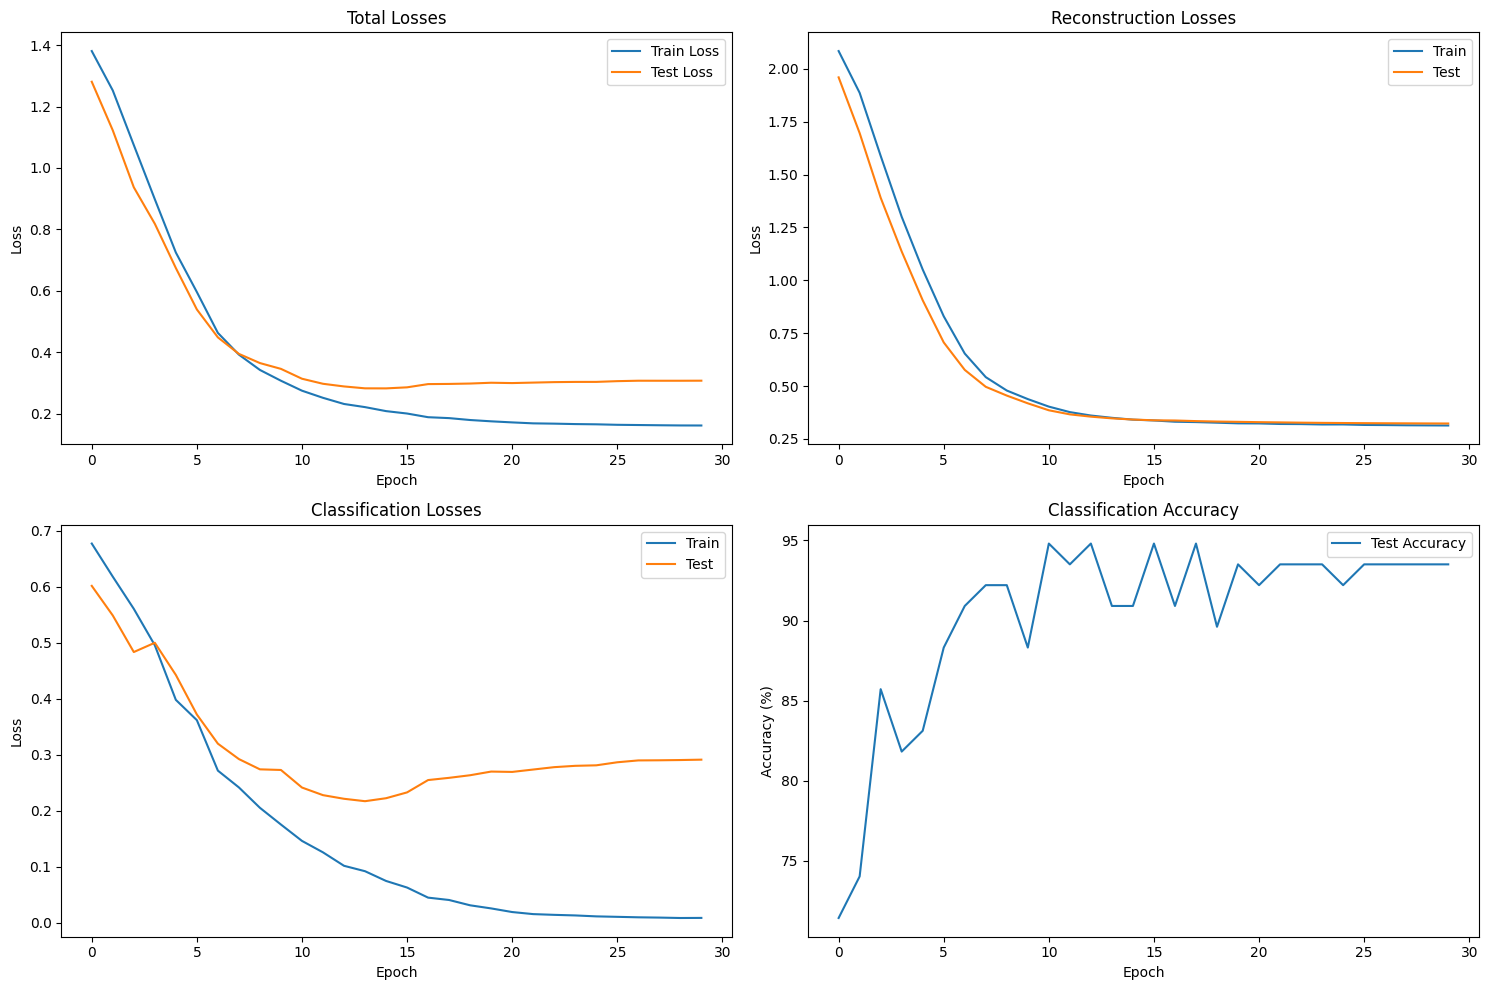

In [14]:
# Creare l'istanza del modello
model = SAE(input_shape=input_dim, encoder_shape0=256, encoder_shape1=128, alpha=0.5).to(device)

# Train the model
model, best_state = train_autoencoder(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=100,
    device=device
)

In [15]:
embeddings= model.encoder(X_train_tensor).detach().numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


In [16]:
# Supponiamo di avere X_train e y_train ottenuti dal bottleneck del tuo autoencoder
X_train_bottleneck, y_train = extract_bottleneck(model, train_loader)

# Creare e addestrare il Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_bottleneck, y_train)

# Test del modello
X_test_bottleneck, y_test = extract_bottleneck(model, test_loader)

# Predizione
y_pred = random_forest.predict(X_test_bottleneck)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, random_forest.predict_proba(X_test_bottleneck)[:, 1])  # AUC

# Stampa dei risultati
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Report completo
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)